In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
import os

drive.mount('/content/drive/')

# 작업 경로를 my drive로 변경하여 구글 드라이브 접속 후 작업 경로 확인
print('현재 작업 경로 :', os.getcwd())
os.chdir('/content/drive/MyDrive')
print('변경된 작업 경로 :', os.getcwd())

Mounted at /content/drive/
현재 작업 경로 : /content
변경된 작업 경로 : /content/drive/MyDrive


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# 이미지 데이터를 로드하고 전처리하는 함수
def load_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # 흑백 이미지 사용
            img = cv2.resize(img, (64, 64))
            images.append(img)
            labels.append(label)
    return images, labels

In [ ]:
# 데이터 로드 및 전처리
patients_images, patients_labels = load_images("/content/drive/MyDrive/dataset/patients", label="patients")
controls_images, controls_labels = load_images("/content/drive/MyDrive/dataset/controls", label="controls")

# 데이터 합치기
X = np.array(patients_images + controls_images)
y = np.array(patients_labels + controls_labels)

# 레이블을 숫자로 인코딩
le = LabelEncoder()
y = le.fit_transform(y)

# 데이터를 학습 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 테스트 세트를 더 나눠서 검증 세트로 분리
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# 데이터 전처리
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0



In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
from tensorflow.keras import models


import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
# Define hyperparameters
IMG_SIZE = 64
BATCH_SIZE = 30
EPOCHS = 100
NUM_CLASSES = 2

# **모델 구현**

In [ ]:
from tensorflow.keras import layers

# reshape input data appropriately for the GRU layer
# Flatten spatial dimensions

X_train_flat = X_train.reshape((X_train.shape[0], -1, X_train.shape[-1]))
X_val_flat = X_val.reshape((X_val.shape[0], -1, X_val.shape[-1]))
X_test_flat = X_test.reshape((X_test.shape[0], -1, X_test.shape[-1]))

# Utility for our sequence model.
def get_model(input_shape, num_classes):
    frame_features_input = keras.Input(shape=(X_train_flat.shape[1], X_train_flat.shape[2]))

    # Add a Convolutional layer for spatial feature extraction
    x = layers.Conv1D(32, kernel_size=3, activation='relu')(frame_features_input)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # ADD RNN
    x = layers.GRU(16)(frame_features_input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    output = layers.Dense(num_classes, activation="softmax")(x)

    cnn_rnn_model = keras.Model(inputs=frame_features_input, outputs=output)

    cnn_rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return cnn_rnn_model

input_shape = (64, 64, 3)
num_classes = 2  # Binary classification for patients and controls

# Example usage
cnn_rnn_model = get_model(input_shape, num_classes)
cnn_rnn_model.summary()

# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    pa_model = get_model(input_shape, num_classes)  # Pass input_shape and num_classes to the function
    history = pa_model.fit(
        X_train_flat,  # Use X_train_flat instead of X_train
        y_train,
        validation_split=0.5,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    #pa_model.load_weights(filepath)
    _, accuracy = pa_model.evaluate(X_test_flat, y_test)  # Use X_test_flat instead of X_test
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, pa_model

_, pa_model = run_experiment()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64)]          0         
                                                                 
 gru (GRU)                   (None, 16)                3936      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 5154 (20.13 KB)
Trainable params: 5154 (20.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
9/9 [==========

# **결과 분석**

In [ ]:
#Building the Decision Tree Model on our dataset
from sklearn.tree import DecisionTreeRegressor

predicted = pa_model.predict(X_test_flat)

3/3 [==============================] - 0s 10ms/step


In [ ]:
predicted

array([[0.48067036, 0.51932967],
       [0.51801836, 0.4819816 ],
       [0.5136643 , 0.4863358 ],
       [0.46301937, 0.53698057],
       [0.48880187, 0.5111981 ],
       [0.4714541 , 0.52854586],
       [0.509095  , 0.49090502],
       [0.48172498, 0.518275  ],
       [0.47736123, 0.5226388 ],
       [0.5028061 , 0.49719387],
       [0.45665616, 0.54334384],
       [0.48718554, 0.5128145 ],
       [0.4687301 , 0.53126997],
       [0.49568707, 0.50431293],
       [0.47624114, 0.5237589 ],
       [0.48407954, 0.51592046],
       [0.4796244 , 0.5203756 ],
       [0.48629558, 0.5137045 ],
       [0.48003438, 0.51996565],
       [0.47202194, 0.52797794],
       [0.48606405, 0.51393586],
       [0.48100013, 0.5189998 ],
       [0.4835552 , 0.51644474],
       [0.49938995, 0.50061   ],
       [0.49078906, 0.50921094],
       [0.49469256, 0.5053074 ],
       [0.488085  , 0.5119149 ],
       [0.4796999 , 0.5203001 ],
       [0.47758642, 0.5224136 ],
       [0.53309095, 0.46690908],
       [0.

In [ ]:
num_rows = predicted.shape[0]
print(num_rows)

70


In [ ]:
# 각 행에서 더 큰 값의 인덱스를 추출하여 1 또는 0으로 구성된 리스트 생성
predicted_classes = (predicted[:, 1] > predicted[:, 0]).astype(int)

# 결과 출력
print(predicted_classes)
print(len(predicted_classes))

[1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
70


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.75      0.28      0.41        32
           1       0.60      0.92      0.73        38

    accuracy                           0.63        70
   macro avg       0.68      0.60      0.57        70
weighted avg       0.67      0.63      0.58        70



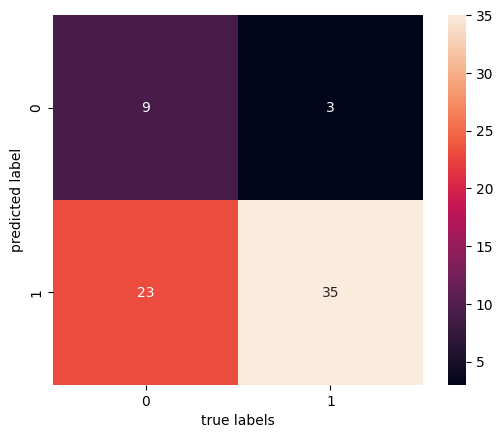

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# plot the confusion matrix
mat = confusion_matrix(y_test, predicted_classes)
sns.heatmap(mat.T, square = True, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)), fmt = "d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()